# MNIST Handwritten Digit Recognition

This example is taken from [MNIST Handwritten Digit Recognition in PyTorch](https://nextjournal.com/gkoehler/pytorch-mnist) by Gregor Koehler. It is a simple convolutional neural network in PyTorch and train it to recognize handwritten digits using the MNIST dataset. It is the hello world of ML. It does not require GPU.

In [1]:
import torch
import torchvision

Define the hyperparameters.

In [2]:
n_epochs = 9
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

For repeatable experiments, set random seeds for anything using random number generation including numpy and random. It's also worth mentioning that cuDNN uses nondeterministic algorithms which can be disabled setting torch.backends.cudnn.enabled = False.

In [3]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

DataLoaders is needed for the dataset. We use TorchVision to load the MNIST dataset in a handy way. We'll use a batch_size of 64 for training and size 1000 for testing on this dataset. The values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset.

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

We use the test_loader take a look at some examples. 

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

let's see what one test data batch consists of.

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

So one test data batch is a  tensor of shape: torch.Size([1000, 1, 28, 28]). This means we have 1000 examples of 28x28 pixels in grayscale. We can plot some of them using matplotlib.

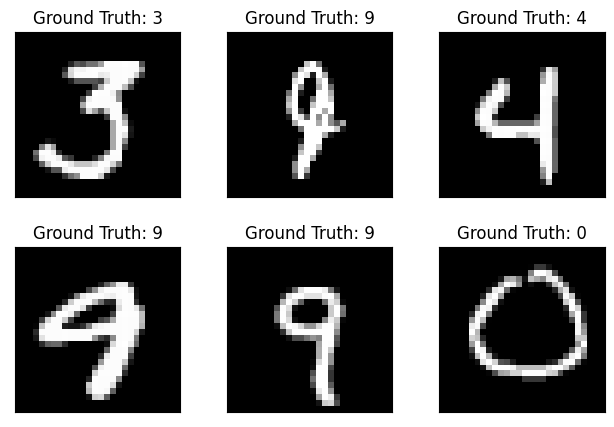

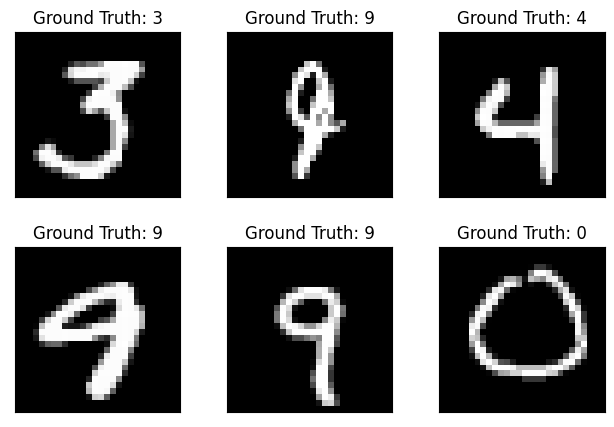

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Build the network.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Initialize the network and the optimizer.

In [10]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Train the model.

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

We'll run our test loop once before even starting the training to see what accuracy/loss we achieve just with randomly initialized network parameters.

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Create results directory to hold training results.

In [14]:
mkdir -p results

In [15]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/tmp/ipykernel_863/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/opt/conda/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248681
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189382
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146366
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107980
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011015
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.842949
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.759084
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.674746
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.683932
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.432250
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.282899
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.313219
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.447374
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.139008
Train Epoch: 1 [12160/6

Evaluate the Model's Performance. Plot the training curve.

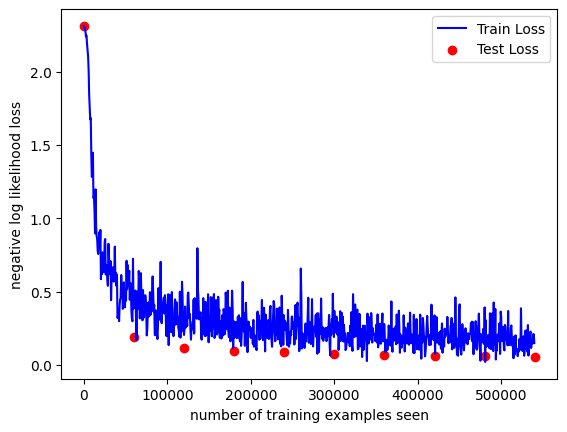

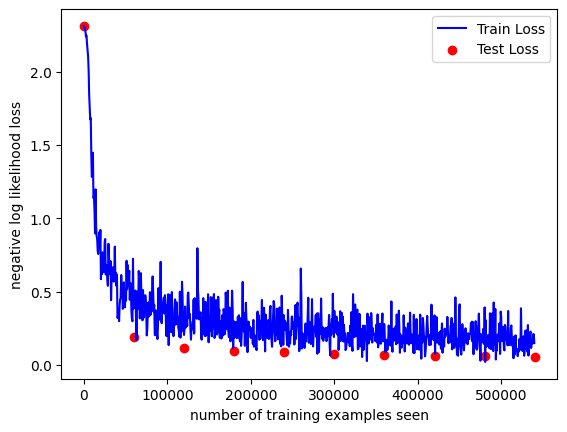

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

Let's again look at a few examples as we did earlier and compare the model's output.

In [17]:
with torch.no_grad():
  output = network(example_data)

/tmp/ipykernel_863/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


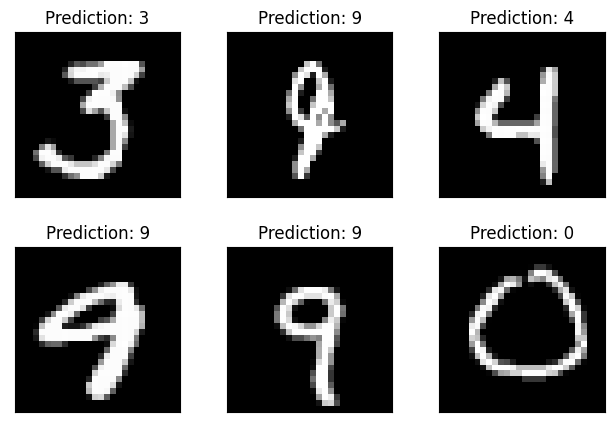

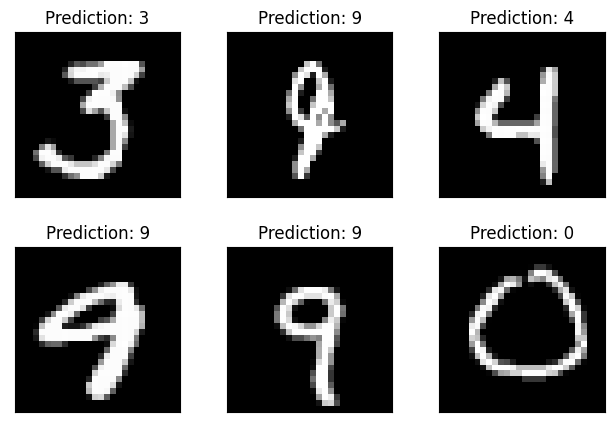

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig